In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

os.environ["HF_ENDPOINT"] = "https://hf-mirror.com"
device = "cuda:4"
dtype = torch.float16

In [3]:
from utils import load_image_data, load_image, pil_to_tensor, display_images
from methods.cds import CDSPipeline

In [4]:
pipe = CDSPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", torch_dtype=dtype
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [5]:
image_data = load_image_data("images/data.json")
print(len(image_data))

5


a photo of a cat
a photo of a tiger


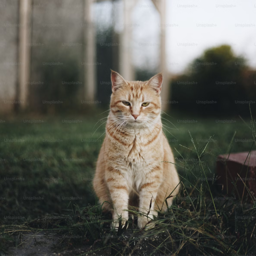

In [6]:
editing_data = image_data[4]
path, source_caption, target_caption = (
    editing_data["path"],
    editing_data["source_caption"],
    editing_data["target_caption"],
)
print(source_caption)
print(target_caption)
image = load_image(path)
image.resize((256, 256))

In [7]:
seed = 1234
image = pil_to_tensor(image, device, dtype)
generator = torch.Generator(device).manual_seed(seed)
results = pipe(
    img=image,
    prompt=source_caption,
    trg_prompt=target_caption,
    num_inference_steps=200,
    generator=generator,
    n_patches=256,
    patch_size=[1, 2],
)

  0%|          | 0/200 [00:00<?, ?it/s]

/data1/junchao/miniconda3/envs/tian/lib/python3.11/site-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:569: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


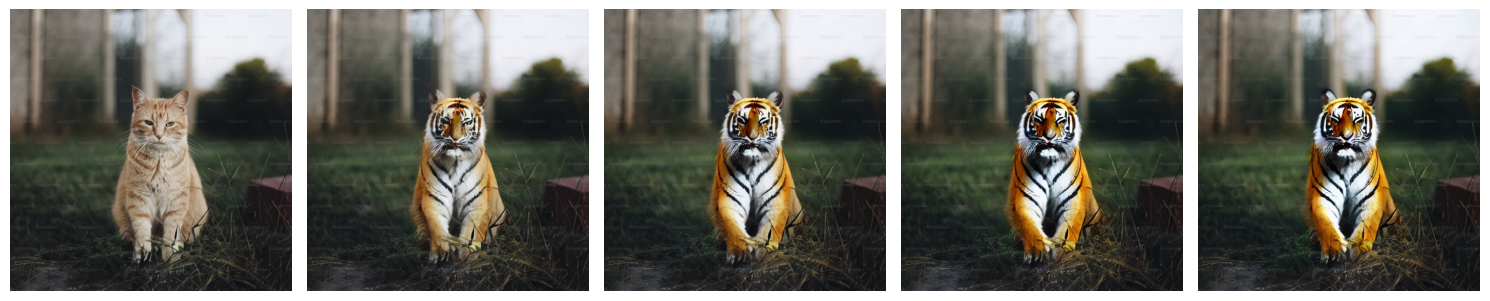

In [8]:
display_images(results)